### Imports

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../kaggle_prediction_library/') 
import preprocess
import feature_engineering
import submission
from sklearn.model_selection import train_test_split

# from hyperopt import tpe, fmin, Trials
# import hyperopt.hp as hp

from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold, RandomizedSearchCV, cross_validate, train_test_split

import matplotlib.pyplot as plt

from yellowbrick.model_selection import ValidationCurve, LearningCurve



In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.feature_selection import chi2
from sklearn.metrics import r2_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import brier_score_loss
from sklearn.neural_network import MLPClassifier



### Data set up

In [6]:
to_predict_mens = pd.read_csv("to_predict_mens.csv")

In [36]:
train = to_predict_mens[to_predict_mens.Season < 2017].copy()
test = to_predict_mens[to_predict_mens.Season >= 2017].copy()

features = [
    'seed_diff', 
            't1_adj_margin', 't2_adj_margin',
                't1_final_rank', 't2_final_rank',
                't1_OrdinalRank', 't2_OrdinalRank',
                't1_FGM', 't1_FGA', 't1_FGM3', 't1_FGA3', 't1_OR',
       't1_Ast', 't1_TO', 't1_Stl', 't1_PF', 't1_PointDiff', 't2_FGM',
       't2_FGA', 't2_FGM3', 't2_FGA3', 't2_OR', 't2_Ast', 't2_TO', 't2_Stl',
       't2_PF', 't2_PointDiff']

target = 'Outcome'

train[target] = train[target].astype(int)

train[features] = MinMaxScaler().fit_transform(train[features])



### Param Tuning

In [14]:
def get_best_params_from_grid_search(train, features, target, model, parameters, scoring, verbose=10):
    gs = GridSearchCV(estimator=model, param_grid=parameters, scoring=scoring, verbose=verbose)
    gs.fit(train[features], train[target])
    return gs.best_params_


In [15]:
model = MLPClassifier(max_iter=1000, random_state=23)

parameters = {'hidden_layer_sizes':[(50,), (100,), (150,)],
              'learning_rate_init':[.0005, .001, .005, .01, .1,],
               'activation':['logistic', 'tanh', 'relu'],
               'alpha':[.0001, .001, .01]
              }

best_params = get_best_params_from_grid_search(train, features, target, model, parameters, 
                                               scoring='neg_brier_score', verbose=15)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
[CV 1/5; 1/135] START activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.0005
[CV 1/5; 1/135] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.0005;, score=-0.185 total time=   1.1s
[CV 2/5; 1/135] START activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.0005
[CV 2/5; 1/135] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.0005;, score=-0.171 total time=   1.2s
[CV 3/5; 1/135] START activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.0005
[CV 3/5; 1/135] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.0005;, score=-0.171 total time=   1.3s
[CV 4/5; 1/135] START activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.0005
[CV 4/5; 1/135] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,

In [16]:
best_params

{'activation': 'logistic',
 'alpha': 0.01,
 'hidden_layer_sizes': (100,),
 'learning_rate_init': 0.001}

### Learning Curve

In [17]:
def plot_learning_curve(train, target, features, model, scoring, xlabel, ylabel, title, yticks=None, sizes=np.linspace(0.1, 1.0, 20), cv=StratifiedKFold(n_splits=10), random_state=23):
    viz = LearningCurve(
        model, cv=cv, scoring=scoring, train_sizes=sizes, n_jobs=-1, random_state=random_state)
    viz.fit(train[features], train[target])
    viz.ax.legend()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    if yticks:
        viz.ax.set_yticks(yticks)
    plt.show()

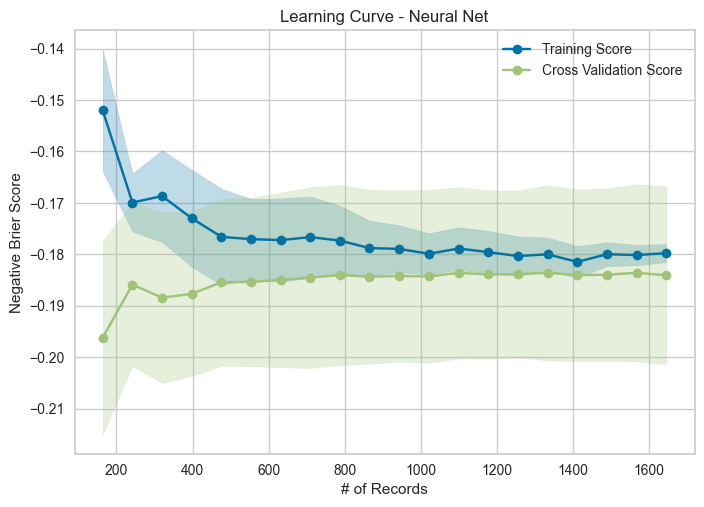

In [18]:
model = MLPClassifier(max_iter=1000, random_state=23, **best_params)

plot_learning_curve(train, 'Outcome', features, model, 
                    'neg_brier_score', 
                    "# of Records", 
                    "Negative Brier Score", 
                    "Learning Curve - Neural Net", 
                    yticks=None, 
                    sizes=np.linspace(0.1, 1.0, 20), 
                    cv=StratifiedKFold(n_splits=10), 
                    random_state=23)


### CV Scoring

In [37]:
def rolling_season_cv(model, train_input, features, label='Outcome', cv_start=2007):
    ''' returns estimate for model performance using shifted validation'''
    
    scores = []

    for n, season in enumerate(train_input.Season.unique()):
        
        if season >= cv_start:

            train = train_input[train_input.Season < season]
            test = train_input[train_input.Season == season]

            X_train = train[features]
            X_test = test[features]
            y_train = train[label]
            y_test = test[label]

            model.fit(X_train[features], y_train)
            y_prob = model.predict_proba(X_test[features])
            loss = brier_score_loss(y_test, y_prob[:,1])
            scores.append((season, loss))

    validation_df = pd.DataFrame(scores, columns = ['season', 'score']).sort_values(by = 'score')
    avg_validation_score = validation_df.score.mean()
    return avg_validation_score


In [38]:
# model = MLPClassifier(max_iter=1000, random_state=23, activation='tanh',
#  alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.005)

model = MLPClassifier(max_iter=1000, random_state=23, **best_params)
rolling_season_cv(model, train, features)

0.18334655075070944

In [ ]:
# 0.18339929273381453

In [ ]:
# can try testing out different cv methods
# for each year, build model with 5 seasons from past and 5 from future
# evaluate whether the future model does better (suggesting bias) or if it doesn't matter  

In [14]:
to_predict_mens.Season.unique()

array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023])

In [ ]:
#2008 - 2017 have 5 seasons on both sides